*UID*: 118775876, 119207666, 118495965


# **CMSC426 Project 1: Color Segmentation using GMM**

# Introduction

Have you ever played with these adorable Nao robots? Click [here](http://www.youtube.com/watch?feature=player_embedded&v=Gy_wbhQxd_0) to watch a cool demo.

Nao robots are star players in RoboCup, an annual autonomous robot soccer competitions. Would you like to help us in Nao’s soccer training? We need to train Nao to detect a soccer ball and estimate the depth of the ball to know how far to kick.

Nao’s training has two phases:

- Color Segmentation using Gaussian Mixture Model (GMM)
- Ball Distance Estimation


<a name='problem'></a>
# What you need to do

To make logistics easier, we have collected camera data from Nao robot on behalf of you and saved the data in the form of color images. Click [here](https://drive.google.com/file/d/17XiM86JqHqko4JC00-E4w4sPKnzh2iMz/view?usp=sharing) to download, or **run the following code block to download the training image folder to the file directory of the notebook**. The image names represent the depth of the ball from Nao robot in centimeters. -We will release the test dataset 48 hours before the deadline.

In [ ]:
# Download training images from Google Drive
import gdown
gdown.download_folder(id="18Mx2Xc9UNFZYajYu9vfmRFlFCcna5I0J", quiet=True, use_cookies=False)
gdown.download_folder(id="1Yl4_5O_ZEkz_KJVs0_vS5TrZUqMYkwr4", quiet=True, use_cookies=False)

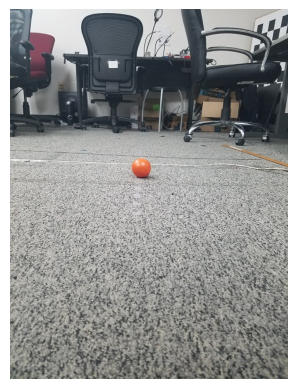

In [17]:
# Check whether the training images were successfully imported
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

train_image = mpimg.imread('/content/train_images/106.jpg')
plt.imshow(train_image)
plt.axis("off")
plt.show()

## Problem Statement

1. Write Python code to cluster the orange ball using [Single Gaussian](https://cmsc426.github.io/colorseg/#gaussian) [30 points]

In [18]:
# TODO: Import all python packages you need
import cv2
import os
from PIL import Image

# TODO: Read in training images
train_images_dir = '/content/train_images/'

images = []
for filename in os.listdir(train_images_dir):
  if filename[-4:]=='.jpg':
    images.append(mpimg.imread(os.path.join(train_images_dir, filename)))

# # TODO: Iterate over training images to extract orange pixels using masks
def extract_orange_pixels(image):

    lower_orange = np.array([200, 70, 30])
    upper_orange = np.array([255, 150, 100])

    mask = cv2.inRange(image, lower_orange, upper_orange)

    orange_pixels = cv2.bitwise_and(image, image, mask=mask)

    return orange_pixels

masked_pixels = []
for image in images:
    orange_pixels = extract_orange_pixels(image)

    # Make pixels that aren't orange black
    non_black_mask = np.any(orange_pixels != [0, 0, 0], axis=2)

    # Append the orange pixels to an array
    masked_pixels.extend(orange_pixels[non_black_mask])

masked_pixels = np.array(masked_pixels)
masked_pixels_cols = masked_pixels.T

# # TODO: Compute mean and covariance using MLE(Maximum Likelihood Estimation)
mean = np.mean(masked_pixels_cols, axis=-1)

def cov(x, y):
  cols = x.shape[0]
  return ((x-x.mean()) * (y-y.mean())).sum()/(cols-1)

var_rr = cov(masked_pixels_cols[0], masked_pixels_cols[0])
var_gg = cov(masked_pixels_cols[1], masked_pixels_cols[1])
var_bb = cov(masked_pixels_cols[2], masked_pixels_cols[2])

var_rg = cov(masked_pixels_cols[0], masked_pixels_cols[1])
var_rb = cov(masked_pixels_cols[0], masked_pixels_cols[2])
var_gb = cov(masked_pixels_cols[1], masked_pixels_cols[2])

covariance = np.array([
    [var_rr, var_rg, var_rb],
    [var_rg, var_gg, var_gb],
    [var_rb, var_gb, var_bb]
])

# TODO: Compute PDF(Probability Density Function) of single gaussian model

cov_inverse = np.linalg.inv(covariance)
cov_det = np.linalg.det(covariance)

def pdf(u, cov, x):
  u = u.reshape((3,1))
  x = x.reshape((3,1))

  a = np.matmul((x-u).T , cov_inverse)
  b = np.matmul(a, (x-u))

  power = -1/2 * b
  power = power[0][0]
  return 1/np.sqrt(((2*np.pi)**3)*cov_det) * np.exp(power)

# # TODO: Set parameters (threshold, prior)
prior = 0.5
threshold = 5e-9

def is_orange(x):
  pdf_val = pdf(mean, covariance, x)
  return prior*pdf_val>=threshold

# # TODO: Send test images into algorithm to detect orange ball
test_images_dir = '/content/test_images/'
test_images = []
for filename in os.listdir(test_images_dir):
  if filename[-4:]=='.jpg':
    test_images.append(mpimg.imread(os.path.join(test_images_dir, filename)))

output = []

for test_image in test_images:
    copy_test_image = np.copy(test_image)

    # Pass the pixels to our orange pixel filter
    orange_mask = np.apply_along_axis(is_orange, axis=2, arr=test_image)

    # Make pixels that aren't ornage black
    copy_test_image[~orange_mask] = [0, 0, 0]

    output.append(copy_test_image)

# source
# https://cmsc426.github.io/colorseg/#gmm

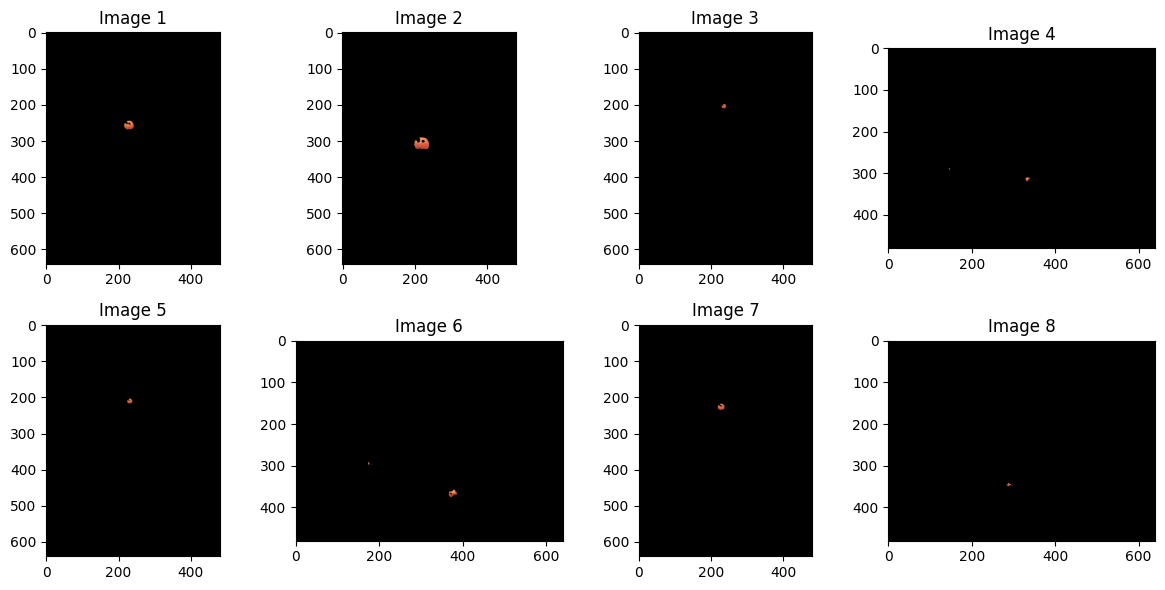

In [19]:
# Plot the test images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# Plot the results of the test images
for i, ax in enumerate(axes.ravel()):
    ax.imshow(output[i])
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

2. Write Python code to cluster the orange ball using [Gaussian Mixture Model](https://cmsc426.github.io/colorseg/#gmm) [40 points] and estimate the [distance](https://cmsc426.github.io/colorseg/#distest) to the ball [20 points]. Also, plot all the GMM ellipsoids [10 points].


You are NOT allowed to use any built-in Python package(s) like *sklearn.mixture.GaussianMixture* for GMM. To help you with code implementation, we have given the pseudocode :-)


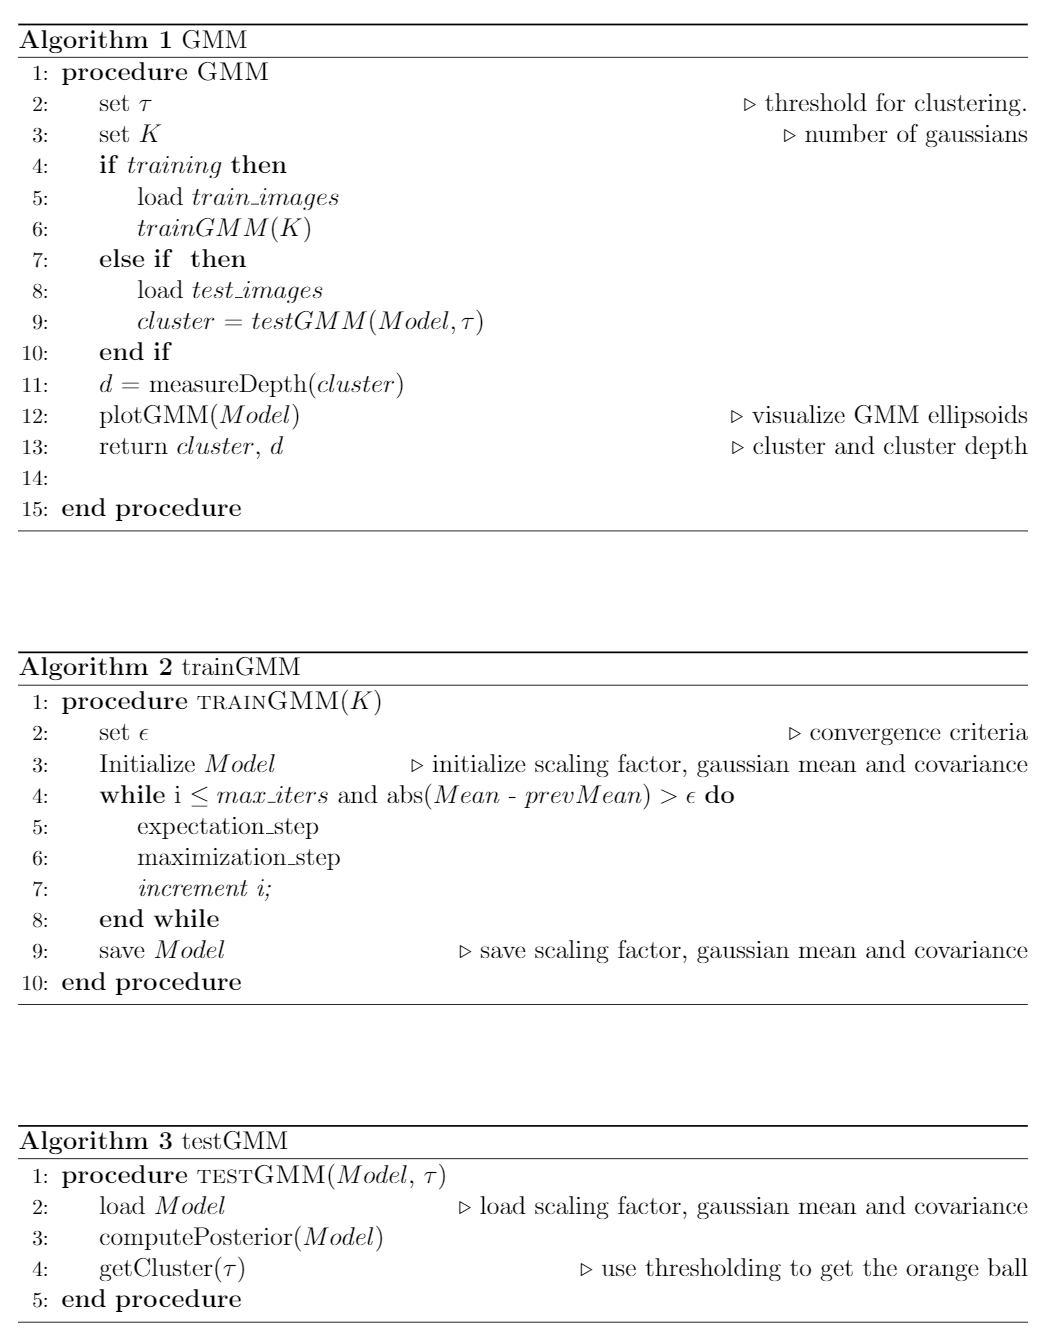

In [20]:
# PDF for GMM
def pdf2(u, x, cov_det, cov_inverse):
  u = u.reshape((3,1))
  x = x.reshape((3,1))

  a = np.matmul((x-u).T , cov_inverse)
  b = np.matmul(a, (x-u))

  power = -1/2 * b
  power = power[0][0]

  return 1/np.sqrt(((2*np.pi)**3)*cov_det) * np.exp(power)

# generate start values for mean and covariance
def gen_random_mean_covariance(pixels, K):

  # generate random means
  mean = np.mean(pixels.T, axis=-1)
  means = []

  for i in range(K):
    temp_mean = []
    for j in range(len(mean)):
      temp_mean.append(np.random.normal(mean[j], np.std(pixels.T[j]), 1)[0])
    means.append(temp_mean)

  # generate random covariance matrices
  covariances = []

  for i in range(K):

    noisy_pixels = np.random.normal(mean, np.std(pixels.T), pixels.shape)

    masked_pixels_cols = noisy_pixels.T

    var_rr = cov(masked_pixels_cols[0], masked_pixels_cols[0])
    var_gg = cov(masked_pixels_cols[1], masked_pixels_cols[1])
    var_bb = cov(masked_pixels_cols[2], masked_pixels_cols[2])

    var_rg = cov(masked_pixels_cols[0], masked_pixels_cols[1])
    var_rb = cov(masked_pixels_cols[0], masked_pixels_cols[2])
    var_gb = cov(masked_pixels_cols[1], masked_pixels_cols[2])

    covariance = np.array([
        [var_rr, var_rg, var_rb],
        [var_rg, var_gg, var_gb],
        [var_rb, var_gb, var_bb]
    ])

    covariances.append(covariance)

  return np.array(means), np.array(covariances)



def trainGMM(K, pixels):

  # TODO: Set convergence criteria and initialize scaling factor, gaussian mean and covariance

  # threshold init
  tau = 5e-6

  # model init
  scaling_factors = np.random.rand(K)
  gaussian_means, covariances = gen_random_mean_covariance(masked_pixels, K)
  previous_means = gaussian_means + (100 * tau)

  # maximum iterations
  max_iters = 200
  curr_iter = 0

  # TODO: Main training algorithm (EM algorithm)

  while curr_iter < max_iters and np.sum(np.linalg.norm(gaussian_means - previous_means)) > tau:

    print("Iteration: " + str(curr_iter + 1))

    # create a cluster dictionary
    clusters = {}
    for k in range(K):
      clusters["cluster_" + str(k)] = []

    # create dictionary for covariance inverse and determinants
    cluster_covs = {}
    for k in range(K):
      cluster_covs["cluster_" + str(k)] = {
          'inverse': np.linalg.inv(covariances[k]),
          'det': np.linalg.det(covariances[k])

      }

    # expectation step
    for pixel in masked_pixels:

      cluster_weights = []
      sum_of_cluster_weights = 0

      for cluster_index in range(K):

        scaling_factor = scaling_factors[cluster_index]
        mean = gaussian_means[cluster_index]
        cov_matrix = covariances[cluster_index]

        cov_det = cluster_covs['cluster_' + str(cluster_index)]['det']
        cov_inverse = cluster_covs['cluster_' + str(cluster_index)]['inverse']

        # calculate undivided cluster weight

        cluster_weight_undivided = scaling_factor * pdf2(mean, pixel, cov_det, cov_inverse)
        sum_of_cluster_weights += cluster_weight_undivided
        cluster_weights.append(cluster_weight_undivided)

      # get index of max
      assigned_cluster_index = np.argmax(np.array(cluster_weights))

      final_weight = cluster_weights[assigned_cluster_index]/sum_of_cluster_weights

      clusters["cluster_" + str(assigned_cluster_index)].append(
          [pixel, final_weight, pixel*final_weight]
      )

    for cluster_key in clusters:
      clusters[cluster_key] = np.array(clusters[cluster_key])

    previous_means = gaussian_means.copy()

    # maximization step
    for cluster_key in clusters:

      cluster_pixels = clusters[cluster_key]
      cluster_index = int(cluster_key.split("_")[-1])

      if not len(cluster_pixels):
        continue

      sum_of_weights = np.sum(cluster_pixels[:, 1])

      # calculate and store new gaussian mean
      new_gaussian_mean = np.sum(cluster_pixels[:, 2])/sum_of_weights
      gaussian_means[cluster_index] = new_gaussian_mean

      # calculate and store new covariance matrix
      sum_of_cov_matrices = np.zeros((3, 3))
      for datapoint in cluster_pixels:
        difference = (datapoint[0] - new_gaussian_mean)
        difference = difference.reshape((3, 1))
        sum_of_cov_matrices += datapoint[1] * np.matmul(difference, difference.T)

      new_covariance_matrix = sum_of_cov_matrices/sum_of_weights
      covariances[cluster_index] = new_covariance_matrix

      # calculate and store new scaling factor
      scaling_factors[cluster_index] = sum_of_weights/len(masked_pixels)

    curr_iter += 1

  return scaling_factors, gaussian_means, covariances


def testGMM(Model_parameters, threshold, prior):

  local_thresh = threshold

  scaling_factors, gaussian_means, covariances = Model_parameters

# TODO:  Read test images
  test_images_dir = '/content/test_images/'
  results_dir = '/content/results'

  images = []

  cov_dets_inverses = {}
  for i in range(len(covariances)):
    cov_dets_inverses[i] = {
        "det": np.linalg.det(covariances[i]),
        "inv": np.linalg.inv(covariances[i])
    }

  def is_orange_gmm(x):

    sum_of_predictions = 0

    for i in range(len(gaussian_means)):

      mean = gaussian_means[i]
      scale = scaling_factors[i]
      cov_matrix = covariances[i]

      cov_det = cov_dets_inverses[i]["det"]
      cov_inverse = cov_dets_inverses[i]["inv"]

      sum_of_predictions += scale * pdf2(mean, x, cov_det, cov_inverse)

    return sum_of_predictions*prior >= local_thresh

  # TODO:  Main testing loop over all test images and use thresholding to get the orange ball

  cluster_parameters = {}

  for filename in os.listdir(test_images_dir):
    if filename[-4:]=='.jpg':

      # Read in image
      copy_test_image = mpimg.imread(os.path.join(test_images_dir, filename)).copy()

      # Pass the pixels with our orange filter
      orange_mask = np.apply_along_axis(is_orange_gmm, axis=2, arr=copy_test_image)

      # Make pixels that aren't orange black
      copy_test_image[~orange_mask] = [0, 0, 0]

      # TODO: Saving predictions to the result folder
      output.append(copy_test_image)
      im = Image.fromarray(copy_test_image)
      im.save(os.path.join(results_dir, filename))

      # Create a boolean mask for non-black pixels
      non_black_mask = np.any(copy_test_image != [0, 0, 0], axis=2)

      # Use the mask to extract non-black pixels and append them to the cluster parameters
      cluster_parameters[filename] = len(copy_test_image[non_black_mask])

  return cluster_parameters

def measureDepth(cluster_parameters):

  alpha = 3e8
  beta = 1e3

  distances = {}
  for param_key in cluster_parameters:
    params = cluster_parameters[param_key]
    distances[param_key] = alpha/((params + beta)**2)

  return distances

def plotGMM(Model_parameters):
  def generate_3d_ellipsoid(scaling_factor, mean, std):
      u = np.linspace(0, 2 * np.pi, 100)
      v = np.linspace(0, np.pi, 100)

      # the ellipsoids will show the colors
      colors = np.zeros((len(u), len(v), 3))

      # calculate points on the ellipsoid
      x = (mean[0] + (std[0] * np.outer(np.cos(u), np.sin(v)))*scaling_factor)/255
      y = (mean[1] + (std[1] * np.outer(np.sin(u), np.sin(v)))*scaling_factor)/255
      z = (mean[2] + (std[2] * np.outer(np.ones_like(u), np.cos(v)))*scaling_factor)/255

      colors[..., 0] = x
      colors[..., 1] = y
      colors[..., 2] = z

      return x, y, z, colors

  (scaling_factors, means, covariances) = Model_parameters
  # Plot ellipsoid
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  for i in range(len(scaling_factors)):

    # Mean and standard deviations along the three axes
    mean = means[i]  # Mean
    std = [covariances[i][0][0], covariances[i][1][1], covariances[i][2][2]] # Standard deviations
    std = np.sqrt(np.array(std))

    scaler = scaling_factors[i]

    # Get points of the ellipsoid
    x, y, z, colors = generate_3d_ellipsoid(scaler, mean, std)

    # Plot the ellipsoid
    ax.plot_surface(x, y, z, facecolors=colors, linewidth=0.02, alpha = 0.1, antialiased=False)

  ax.set_xlabel('X-axis')
  ax.set_ylabel('Y-axis')
  ax.set_zlabel('Z-axis')

  # Show the plot
  plt.show()

# citation for ellipsoid plot:
# https://matplotlib.org/stable/gallery/mplot3d/surface3d_2.html#sphx-glr-gallery-mplot3d-surface3d-2-py

Iteration: 1


<ipython-input-20-e372da754833>:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clusters[cluster_key] = np.array(clusters[cluster_key])


Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Distance to ball in image 5.jpg: 95.11200389578768
Distance to ball in image 4.jpg: 52.432299414995356
Distance to ball in image 8.jpg: 159.8380307954606
Distance to ball in image 2.jpg: 152.8427996521298
Distance to ball in image 7.jpg: 153.28011788262933
Distance to ball in image 3.jpg: 96.08335423146288
Distance to ball in image 6.jpg: 132.2730327031846
Distance to ball in image 1.jpg: 121.09098130516703


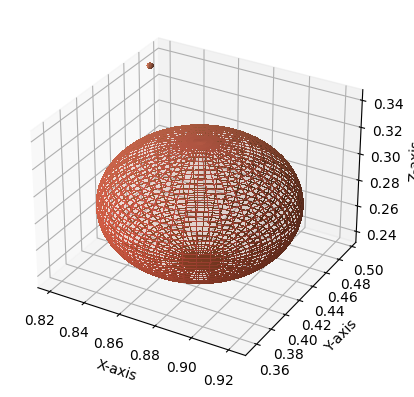

In [21]:
# Main function (Algorithm 1 in the pseudocode above)
distances = []
# TODO: Import all python packages you need
def GMM(threshold, K, mode_flag, model_params):
  if mode_flag == 0:

    train_images_dir = '/content/train_images/'

    images = []
    for filename in os.listdir(train_images_dir):
      if filename[-4:]=='.jpg':
        images.append(mpimg.imread(os.path.join(train_images_dir, filename)))

    # # TODO: Iterate over training images to extract orange pixels using masks
    def extract_orange_pixels(image):

      lower_orange = np.array([200, 70, 30])
      upper_orange = np.array([255, 150, 100])

      mask = cv2.inRange(image, lower_orange, upper_orange)

      orange_pixels = cv2.bitwise_and(image, image, mask=mask)

      return orange_pixels

    masked_pixels = []
    for image in images:
        orange_pixels = extract_orange_pixels(image)

        # Pass the pixels with our orange filter
        non_black_mask = np.any(orange_pixels != [0, 0, 0], axis=2)

        # Find the orange pixels
        masked_pixels.extend(orange_pixels[non_black_mask])

    masked_pixels = np.array(masked_pixels)

    # -Write Python code to cluster the orange ball using Gaussian Mixture Model [40 points].
    pis, mus, sigmas = trainGMM(K, masked_pixels)

    return (pis, mus, sigmas)

  else:

    cluster_parameters = testGMM(model_params, threshold, 0.5)
    global distances

    # -Estimate the distance to the ball [20 points].
    distances = measureDepth(cluster_parameters)

    for key in distances:
      print(f"Distance to ball in image {key}: " + str(distances[key]))

    # Plot all the GMM ellipsoids [10 points].
    plotGMM(model_params)

!rm -rf results
!mkdir results

threshold = 5e-20
K = 2

model_params = GMM(threshold, K, 0, None)

GMM(threshold, K, 1, model_params)

# source
# https://cmsc426.github.io/colorseg/#gmm

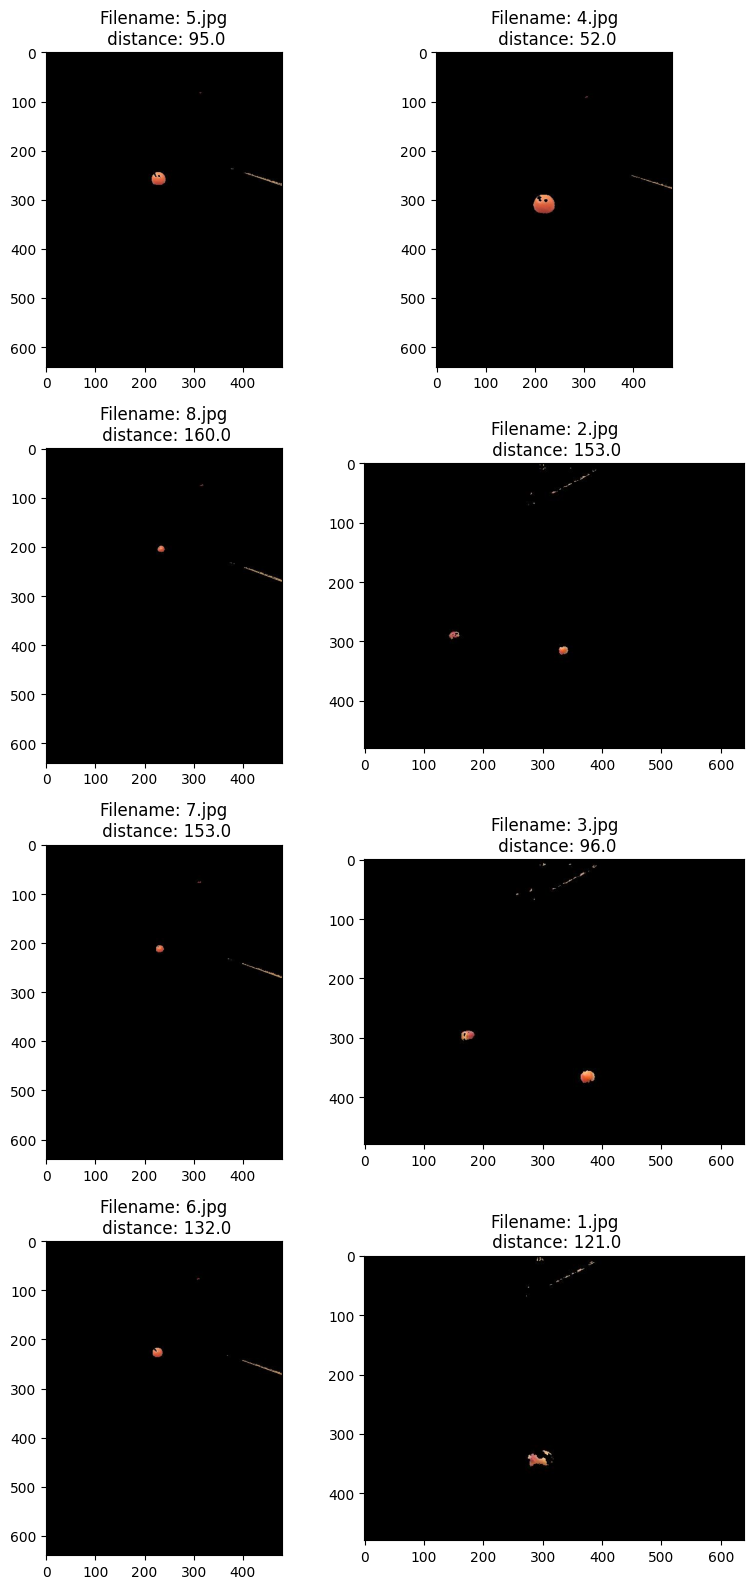

In [23]:
# Plot results of test images for GMM
output = []
results_dir = '/content/results'
filenames = []
for filename in os.listdir(results_dir):
  if filename[-4:]=='.jpg':
    output.append(mpimg.imread(os.path.join(results_dir, filename)))
    filenames.append(filename)

fig, axes = plt.subplots(4, 2, figsize=(8, 16))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(output[i])
    ax.set_title(f"Filename: {filenames[i]}\n distance: {round(distances[filenames[i]], 0)}")


plt.tight_layout()
plt.show()

# Video Lecture
Click [here](https://www.youtube.com/watch?v=D5AcaFMY_BI) for a video lecture to help you better understand the project.

## Report
For each section of the project, explain briefly what you did, and describe any interesting problems you encountered and/or solutions you implemented. You must include the following details in your writeup:

- Your choice of color space, initialization method and number of gaussians in the GMM
- Explain why GMM is better than single gaussian
- Present your distance estimate and cluster segmentation results for each test image
- Explain strengths and limitations of your algorithm. Also, explain why the algorithm failed on some test images

As usual, your report must be full English sentences, not commented code. There is a word limit of 1500 words and no minimum length requirement.

#**Report**

##Part 1:

In Part 1, we used a Single Gaussian to determine if pixels were orange. We used openCV to mask each image and extract the orange pixels in the images. We defined our own range of acceptable RGB values of orange using trial and error. We used RGB as our color space. Once we had the orange pixels from each image, we calculated the mean and covariance of these values. These two values are then used as arguments to calculate the MLE using a uniform distribution. The likelihood is then multiplied by a Prior, which was set as 0.5. This was under the assumption that an orange pixel was just as likely as a pixel of any other color. If the product was greater than a threshold value, it was considered to be an orange pixel. Now that we have a way to check if pixels are orange, we checked every image in the test folder in a plot.

##Part 2:
In Part 2, we used multiple Gaussians to determine if pixels were orange. Since we already determined the orange pixels from the training images in Part 1, we did not have to find training data again.

We set out to train a Gaussian Mixture model using 2 distributions. We set a convergence threshold “tau” to 5e-6, which proved low enough to result in reasonable convergence. We first set the Gaussians to have a random covariance, scaling factor, and mean. However, because we ran into exploding/vanishing multiplication issues, we decided to center these randomly  generated covariance/mean values around the values we got from the Single Gaussian model from part 1. This was a good approach to ensure that our model converged while still introducing randomness for the best results. We iterated for a maximum of 200 iterations, executing an expectation step and a maximization step every time. The expectation step consisted of assigning cluster weights to pixels based on the current iteration’s scaling factor, mean and standard deviation for each gaussian distribution. Once these pixels were assigned their clusters, we moved on to the maximization algorithm where we optimized each distribution’s model parameters based on the pixels assigned in each cluster. The sum of these distributions results in a more robust prediction method than a single gaussian because we have introduced the ability to describe even further nonlinear behavior than a single normal curve. This resulted in a better distance estimation metric.

We can visualize the gaussians by plotting their ellipsoids, which represent acceptable orange pixel values, in the color space. The means, standard deviations and sizes of these ellipsoids come directly from the GMM parameters and are an accurate representation of the models in the GMM too..

In order to determine the distance of the ball, we found that there is an inverse relationship between the number of orange pixels in the image and the distance of the ball. Thus, as the number of pixels increases, the ball is closer to the camera. We predicted the distance by multiplying the inverse squared of the number of orange pixels by a scaling factor and adding a constant bias.

We plotted each test image after the multiple Gaussian mask with the predicted distance.

## Failures

Our algorithm failed on some of our test images (1-3) because there was an apple in the picture. The color distribution of an apple contains some colors that are similar to the orange ball we were meant to detect, so the GMM picked up on both of them. This resulted in more pixels in the image associated with the orange ball than anticipated, artificially reducing the distances. We could try to define the color “orange” better and train a GMM with a higher K to combat this.


# Submission Guidelines

**If your submission does not comply with the following guidelines, you’ll be given ZERO credit.**

Your submission on ELMS(Canvas) must be a pdf file, following the naming convention **YourDirectoryID_proj1.pdf**. For example, xyz123_proj1.pdf.

**All your results and report should be included in this notebook. After you finished all, please export the notebook as a pdf file and submit it to ELMS(Canvas).**

# Collaboration Policy
You are encouraged to discuss the ideas with your peers. However, the code should be your own, and should be the result of you exercising your own understanding of it. If you reference anyone else’s code in writing your project, you must properly cite it in your code (in comments) and your writeup. For the full honor code refer to the CMSC426 Fall 2023 website.